## Seq2Sql

Задача перевода запросов на натуральном языке в машинный код аналогична задаче перевода "последовательность-в-последовательность" 

<img src="files/lstm.png">


## Dataset: GEOQUERY

Это база данных о географических объектах, плотности населения, границах штатов и т.д. Соединенных Штатов Америки
GEOQUERY: lambda calculus
* “Plus 1” function: ƛx.x+1
* “Plus 1” function, where argument == 3: (ƛx.x+1)3 => 3+1 =>4
*  all capital cities λx.capital(x)
*  capital(p)  λp.λx.(capital(x), p(x))

Примеры запросов в табличке:
<img src="files/table3.png">

больше о языке запросов:
http://www.cs.utexas.edu/~ml/wasp/geo-funql.html


### Словари


* Обычно: модель работает со словарями слов, которые возможно встретить во входных и выходных последовательностях.
* Cловарь каждому слову присваивает номер, по номеру слова словарь дает слово. Т.е класс "словарь" содержит стурктуры word2index, index2word. Например, в util_tf.py класс Vocab
* на вход модели дается не набор слов, в набор номеров слов в словаре. 

## BPE!
**Byte Pair Encoding.**

Токенезирует на уровне символов (т.е. побуквенно), заменяет часто встречающиеся символы одним токеном. Затем вместо словаря слов появляется словарь токенов.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
tokenizer = WordPunctTokenizer()

def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

def preprocess(dataset_type, datadir, source_voc_type, dist_voc_type): #создает bpe-словарики из слов в словарях sourcevoc(это все возможные слова, 
    # которые могут встретиться в вопросах на натуральном языке по этой базе данных), targetvoc(символы математического языка запроса)
    with open("{}.{}".format(dataset_type,source_voc_type), 'w') as f_src,  open("{}.{}".format(dataset_type, dist_voc_type), 'w') as f_dst:
        for line in open('{}/{}.txt'.format(datadir, dataset_type), encoding='utf-8'):
            src_line, dst_line = line.strip().split('\t')

            f_src.write(tokenize(src_line) + '\n')
            f_dst.write(tokenize(dst_line) + '\n')
        
    bpe = {}
    for v_type in [source_voc_type, dist_voc_type]:
        learn_bpe(open('./{}.'.format(dataset_type) + v_type), open('bpe_rules.' + v_type, 'w'), num_symbols=8000)
        bpe[v_type] = BPE(open('./bpe_rules.' + v_type))
        with open('{}.bpe.'.format(dataset_type) + v_type, 'w') as f_out:
            for line in open('{}.'.format(dataset_type) + v_type):
                f_out.write(bpe[v_type].process_line(line.strip()) + '\n')

In [4]:
preprocess('train', 'data', 'qw', 'qu')

no pair has frequency >= 2. Stopping
no pair has frequency >= 2. Stopping


In [5]:
preprocess('test', 'data', 'qw', 'qu')

no pair has frequency >= 2. Stopping
no pair has frequency >= 2. Stopping


**определим train и test и посмотрим на данные**

In [6]:
train_inp = np.array(open('./train.bpe.qw').read().split('\n'))
train_out = np.array(open('./train.bpe.qu').read().split('\n'))
test_inp = np.array(open('./test.bpe.qw').read().split('\n'))
test_out = np.array(open('./test.bpe.qu').read().split('\n'))

for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: where is c0
out: ( lambda $ 0 e ( loc : t c0 $ 0 ) )

inp: where is m0
out: ( lambda $ 0 e ( loc : t m0 $ 0 ) )

inp: where is c0
out: ( lambda $ 0 e ( loc : t c0 $ 0 ) )



In [7]:
from util_tf import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

**to_matrix, to_line**
* у класса vocab есть функция to_matrix, которая из батча вопросов на естественном языке генерит батч чисел, где число - индекс соответсвующего слова в словаре.

* И функция to_lines, которая батч чисел переводит обратно

* Важно! модель предсказывает батч чисел

In [8]:
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['where is s0', 'peopl in c0', 'where is c0', 'where is c0', 'popul of c0']

words to ids (0 = bos, 1 = eos):
[[  0 137  59 109   1]
 [  0 102  58  19   1]
 [  0 137  59  19   1]
 [  0 137  59  19   1]
 [  0 105  95  19   1]]

back to words
['where is s0', 'peopl in c0', 'where is c0', 'where is c0', 'popul of c0']


### Модель


In [9]:
import tensorflow as tf
import keras.layers as L
from util_tf import infer_length, infer_mask

Using TensorFlow backend.


In [23]:
class BasicModel:
    def __init__(self, name, inp_voc, out_voc, emb_size=64, hid_size=128):
        
        self.name, self.inp_voc, self.out_voc = name, inp_voc, out_voc

        with tf.variable_scope(name):
            self.emb_inp = L.Embedding(len(inp_voc), emb_size)
            self.emb_out = L.Embedding(len(out_voc), emb_size)
            self.enc0 = tf.nn.rnn_cell.GRUCell(hid_size)

            self.dec_start = L.Dense(hid_size)
            self.dec0 = tf.nn.rnn_cell.GRUCell(hid_size)
            self.logits = L.Dense(len(out_voc))

            # prepare to translate_lines
            self.inp = tf.placeholder('int32', [None, None])
            self.initial_state = self.prev_state = self.encode(self.inp)
            self.prev_tokens = tf.placeholder('int32', [None])
            self.next_state, self.next_logits = self.decode(self.prev_state, self.prev_tokens)
        
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)

    def encode(self, inp, **flags):
        """
        Получает на вход батч, прогоняет его через emb_layer (теперь каждому числу-слову соответсвует вектор)
        возвращает начальное состояние для rnn-ки декодера
        """
        inp_lengths = infer_length(inp, self.inp_voc.eos_ix)
        inp_emb = self.emb_inp(inp)
        with tf.variable_scope('enc0'):
            _, enc_last = tf.nn.dynamic_rnn(
                              self.enc0, inp_emb,
                              sequence_length=inp_lengths,
                              dtype = inp_emb.dtype)
        dec_start = self.dec_start(enc_last)
        print ("dec_start.shape", dec_start.shape)
        return [dec_start]

    def decode(self, prev_state, prev_tokens, **flags):
        """
        берет предыдущее состояние, возвращает вероятности для всех символов выходного словаря и состояние для следующей ячейки
        """
        [prev_dec] = prev_state
        prev_emb = self.emb_out(prev_tokens[:,None])[:,0]
        with tf.variable_scope('dec0'):
            new_dec_out, new_dec_state = self.dec0(prev_emb, prev_dec)
        output_logits = self.logits(new_dec_out)
        return [new_dec_state], output_logits

    def translate_lines(self, inp_lines, max_len=100):
        state = sess.run(self.initial_state, {self.inp: inp_voc.to_matrix(inp_lines)})
        outputs = [[self.out_voc.bos_ix] for _ in range(len(inp_lines))]
        all_states = [state]
        finished = [False] * len(inp_lines)

        for t in range(max_len):
            state, logits = sess.run([self.next_state, self.next_logits], {**dict(zip(self.prev_state, state)),
                                           self.prev_tokens: [out_i[-1] for out_i in outputs]})
            next_tokens = np.argmax(logits, axis=-1)
            all_states.append(state)
            for i in range(len(next_tokens)):
                outputs[i].append(next_tokens[i])
                finished[i] |= next_tokens[i] == self.out_voc.eos_ix
        return out_voc.to_lines(outputs), all_states

In [24]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

model = BasicModel('model', inp_voc, out_voc)
sess.run(tf.global_variables_initializer())

/opt/anaconda/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


dec_start.shape (?, 128)


### Loss 

$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$


In [60]:
def compute_logits(model, inp, out, **flags):
   
    batch_size = tf.shape(inp)[0]
    
    first_state = model.encode(inp)
    
    first_logits = tf.log(tf.one_hot(tf.fill([batch_size], model.out_voc.bos_ix),
                                     len(model.out_voc)) + 1e-30)
    
    def step(prev_tupl, y_prev):
        prev_state, logits = prev_tupl
        next_state, logits = model.decode(prev_state, y_prev)
        
        return [next_state, logits]
    
    h_seq, logits_seq = tf.scan(step, elems=tf.transpose(out)[:-1], initializer=[first_state, first_logits])
    
    logits_seq = tf.concat([first_logits[None], logits_seq], axis = 0)
    #print ("inp shape", inp.shape)
    #print ("logits_seq.shape", logits_seq.shape)
    # Make sure you convert logits_seq from [time, batch, voc_size] to [batch, time, voc_size]
    logits_seq = tf.transpose(logits_seq, (1, 0, 2))
    
    #print ("logits_seq.shape", logits_seq.shape)
    
    return logits_seq

In [61]:
from util_tf import select_values_over_last_axis

def compute_loss(model, inp, out, **flags):
    mask = infer_mask(out, out_voc.eos_ix)    
    logits_seq = compute_logits(model, inp, out, **flags)
    #print ("logits_seq.shape", logits_seq.shape)
    soft_max = tf.nn.log_softmax(logits_seq, -1)
    #print ("soft max shape", soft_max.shape)
    #print ("out shape", out.shape)
    #print ("out", sess.run(out[2]))
    symbols = select_values_over_last_axis(soft_max, out)
    #print ("symbols.shape", symbols.shape)
    symbols = symbols*mask
    
    return -tf.reduce_sum(symbols)/tf.reduce_sum(mask)

In [62]:
train_inp[:3]

array(['where is c0', 'where is m0', 'where is c0'], dtype='<U94')

In [63]:
len(out_voc.tokens)

70

In [64]:
dummy_inp = tf.constant(inp_voc.to_matrix(train_inp[:3]))
dummy_out = tf.constant(out_voc.to_matrix(train_out[:3]))
dummy_loss = sess.run(compute_loss(model, dummy_inp, dummy_out))
print("Loss:", dummy_loss)

dec_start.shape (3, 128)
Loss: 3.9870157


3 запроса длиной 16 символов максимально, на каждом символе - 70 вероятностей

out определяет индекс элемента в реальной последовательности. По этому индексу из logits вытаскивается значение и суммируется. Чем больше значение по реальному индексу(ег овероятность) тем лучше

## Убери весь вывод из лосса!!!!

### Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [65]:
inp = tf.placeholder('int32', [None, None])
out = tf.placeholder('int32', [None, None])

loss = compute_loss(model, inp, out)

train_step = tf.train.AdamOptimizer().minimize(loss)

dec_start.shape (?, 128)


In [66]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': []}

sess.run(tf.global_variables_initializer())
batch_size = 32

In [67]:
batch_size

32

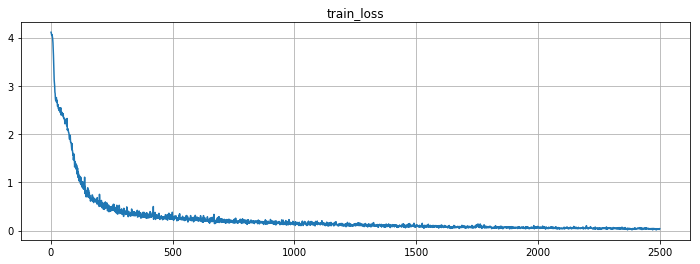

Mean loss=0.030


100%|██████████| 2500/2500 [05:15<00:00,  7.93it/s]


In [68]:
for _ in trange(2500):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    feed_dict = {
        inp: inp_voc.to_matrix(train_inp[batch_ix]),
        out: out_voc.to_matrix(train_out[batch_ix]),
    }
    
    loss_t, _ = sess.run([loss, train_step], feed_dict)
    metrics['train_loss'].append((step, loss_t))
    
    if step % 100 == 0:
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

## Посмотрим, что вышло

In [112]:
for inp_line, query, generated_query in zip(test_inp[:50], test_out[:50], model.translate_lines(test_inp[::50])[0]):
    print("inp_line", inp_line)
    print("real query", query)
    print("generated query", generated_query)
    print()

inp_line where is c0
real query ( lambda $ 0 e ( loc : t c0 $ 0 ) )
generated query ( lambda $ 0 e ( loc : t c0 $ 0 ) )

inp_line river in s0
real query ( lambda $ 0 e ( and ( river : t $ 0 ) ( loc : t $ 0 s0 ) ) )
generated query ( population : i c0 )

inp_line where are mountain
real query ( lambda $ 0 e ( exists $ 1 ( and ( mountain : t $ 1 ) ( loc : t $ 1 $ 0 ) ) ) )
generated query ( count $ 0 ( and ( state : t $ 0 ) ( next_to : t s0 $ 0 ) ) )

inp_line where is c0
real query ( lambda $ 0 e ( loc : t c0 $ 0 ) )
generated query ( argmax $ 0 ( and ( city : t $ 0 ) ( loc : t $ 0 s0 ) ) ( size : i $ 0 ) )

inp_line what state border s0
real query ( lambda $ 0 e ( and ( state : t $ 0 ) ( next_to : t $ 0 s0 ) ) )
generated query ( argmax $ 0 ( state : t $ 0 ) ( count $ 1 ( and ( river : t $ 1 ) ( loc : t $ 1 $ 0 ) ) ) )

inp_line what state border s0
real query ( lambda $ 0 e ( and ( state : t $ 0 ) ( next_to : t $ 0 s0 ) ) )
generated query ( argmax $ 0 ( and ( place : t $ 0 ) ( loc : 

In [113]:
candidate_list = []
reference_list = []

for inp_line, query, generated_query in zip(test_inp, test_out, model.translate_lines(test_inp)[0]):
    candidate_list.append(generated_query)
    reference_list.append(query)

## Metrcic: accuracy
+1 к accuracy, если последовательность символов в запросе полностью совпадает с оригиналом

In [114]:
def is_all_same(c1, c2):
    if len(c1) == len(c2):
        all_same = True
        for j in range(len(c1)):
            if c1[j] != c2[j]:
                all_same = False
                break
        return all_same
    else:
        return False


def compute_accuracy(candidate_list, reference_list):
    if len(candidate_list) != len(reference_list):
        print("candidate list has length {}, reference list has length {}\n".format(len(candidate_list), len(reference_list)))

    len_min = min(len(candidate_list), len(reference_list))
    c = 0
    for i in range(len_min):
        #print(candidate_list[i])
        #print(reference_list[i])
        if is_all_same(candidate_list[i], reference_list[i]):
            #print("above was all same")
            c = c+1
    return c/float(len_min)

In [115]:
compute_accuracy(candidate_list, reference_list)

0.5871886120996441

### Attention

После работы энкодера есть последовательность его скрытых состояний, каждое из которых относиться к токену входной последовательности $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ 
Также есть скрытое состояние декодера с прошлого шага $h^d$,

* Считаем вот такое
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Считаем вес, с которым каждое слово во входной последовательности повлияет на декодер state.
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Добавляем ко внутренему состоянию декодера на предыдущем шаге взвешенную сумму внутренних состояний энкодера.
$$ attn = \sum_t p_t \cdot h^e_t $$

Чуть подробнее тут(https://distill.pub/2016/augmented-rnns/).

In [116]:
class AttentionLayer:
    def __init__(self, name, enc_size, dec_size, hid_size, activ=tf.tanh,):

        self.name = name
        self.enc_size = enc_size 
        self.dec_size = dec_size 
        self.hid_size = hid_size 
        self.activ = activ       

        with tf.variable_scope(name):
            
            self.linear_enc = L.Dense(hid_size)
            self.linear_dec = L.Dense(hid_size)
            self.out = L.Dense(1)

            # prepare to translate_lines
            self.inp = tf.placeholder('int32', [None, None])

    def __call__(self, enc, dec, inp_mask):
        with tf.variable_scope(self.name):
            
            
            adds = self.linear_enc(enc) + self.linear_dec(dec)[:, None, :]
            tanh = tf.tanh(adds)
            logits = self.out(adds)[:, :, 0]
            print (logits.shape)

            
           
            a = tf.equal(inp_mask, 0.0)
            b = logits
            c = tf.fill(tf.shape(logits), -1e9)
            
            logits = tf.where(a, logits, tf.fill(tf.shape(logits), -1e9))
            
            probs = tf.nn.softmax(logits)
            
           
            attn = tf.reduce_sum(tf.multiply(enc,probs), axis=2)
            attn = tf.reduce_sum(probs[:, :, None] * enc, axis=1)
            
            return attn, probs

### Seq2seq с вниманием(attention)


In [117]:
class AttentiveModel(BasicModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        self.name = name
        self.inp_voc = inp_voc
        self.out_voc = out_voc

        with tf.variable_scope(name):
            
            
            self.emb_inp = L.Embedding(len(inp_voc), emb_size)
            self.emb_out = L.Embedding(len(out_voc), emb_size)
            self.enc0 = tf.nn.rnn_cell.GRUCell(hid_size)
            
            self.attn_layer = AttentionLayer("attn1", emb_size, emb_size, hid_size)

            self.dec_start = L.Dense(hid_size)
            self.dec0 = tf.nn.rnn_cell.GRUCell(hid_size)
            self.logits = L.Dense(len(out_voc))

            self.inp = tf.placeholder('int32', [None, None])
            self.initial_state = self.prev_state = self.encode(self.inp)
            self.prev_tokens = tf.placeholder('int32', [None])
            self.next_state, self.next_logits = self.decode(self.prev_state, self.prev_tokens)
        
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        

    def encode(self, inp, **flags):
        # encode input sequence, create initial decoder states
        inp_lengths = infer_length(inp, self.inp_voc.eos_ix)
        inp_mask_ = infer_mask(inp, self.inp_voc.eos_ix)
        inp_emb = self.emb_inp(inp)
        with tf.variable_scope('enc0'):
            _, enc_last = tf.nn.dynamic_rnn(
                              self.enc0, inp_emb,
                              sequence_length=inp_lengths,
                              dtype = inp_emb.dtype)
        
        print ("enc_last shape ", _.shape)
        dec_start = self.dec_start(enc_last)
        print ("enc_last shape ", dec_start.shape)
        
        #!!! Attention мы добавляем в энкодер. Вот тут вся разница
        first_attn, first_attn_probas = self.attn_layer(inp_emb, dec_start, inp_mask_)
        
        first_state = [dec_start, inp_emb, inp_mask_, first_attn_probas]
        return first_state

    def decode(self, prev_state, prev_tokens, **flags):
       
        [dec_start, inp_emb, inp_mask_, first_attn_probas] = prev_state
        
        
        next_attn_response, next_attn_probas = self.attn_layer(inp_emb, dec_start, inp_mask_)
        
        prev_emb = self.emb_out(prev_tokens[:,None])[:,0]
        
        print ("shapes", prev_emb.shape, next_attn_response.shape)
        
        with tf.variable_scope('dec0'):
            aaa = tf.concat([next_attn_response, prev_emb], axis=-1)
            new_dec_out, new_dec_state = self.dec0(aaa, dec_start)
        output_logits = self.logits(new_dec_out)

        next_state = [new_dec_state, inp_emb, inp_mask_, next_attn_probas]
        return next_state, output_logits


In [118]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = AttentiveModel('model_attn', inp_voc, out_voc)

enc_last shape  (?, ?, 128)
enc_last shape  (?, 128)
(?, ?)
(?, ?)
shapes (?, 64) (?, 64)


### Training attentive model

We'll reuse the infrastructure you've built for the regular model. I hope you didn't hard-code anything :)

In [119]:
inp = tf.placeholder('int32', [None, None])
out = tf.placeholder('int32', [None, None])

loss = compute_loss(model, inp, out)
train_step = tf.train.AdamOptimizer().minimize(loss)

enc_last shape  (?, ?, 128)
enc_last shape  (?, 128)
(?, ?)
(?, ?)
shapes (?, 64) (?, 64)
inp shape (?, ?)
logits_seq.shape (?, ?, 70)
logits_seq.shape (?, ?, 70)


In [120]:
metrics = {'train_loss': []}
sess.run(tf.global_variables_initializer())
batch_size = 32

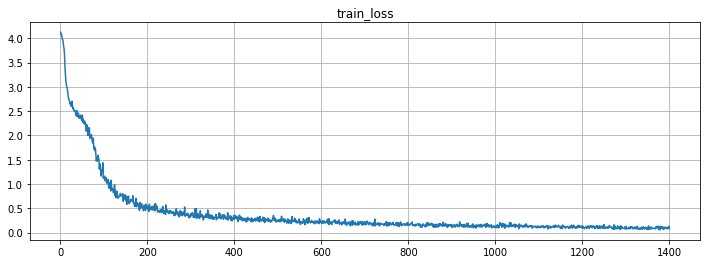

Mean loss=0.097


 59%|█████▊    | 1467/2500 [04:39<03:16,  5.26it/s]

In [ ]:
for _ in trange(2500):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    feed_dict = {
        inp: inp_voc.to_matrix(train_inp[batch_ix]),
        out: out_voc.to_matrix(train_out[batch_ix]),
    }
    
    loss_t, _ = sess.run([loss, train_step], feed_dict)
    metrics['train_loss'].append((step, loss_t))
    
    if step % 100 == 0:
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
        

## Посмотрим, что вышло -2

In [81]:
for inp_line, query, generated_query in zip(test_inp[:50], test_out[:50], model.translate_lines(test_inp[::50])[0]):
    print("inp_line", inp_line)
    print("real query", query)
    print("generated query", generated_query)
    print()

inp_line where is c0
real query ( lambda $ 0 e ( loc : t c0 $ 0 ) )
generated query ( lambda $ 0 e ( loc : t c0 $ 0 ) )

inp_line river in s0
real query ( lambda $ 0 e ( and ( river : t $ 0 ) ( loc : t $ 0 s0 ) ) )
generated query ( population : i c0 )

inp_line where are mountain
real query ( lambda $ 0 e ( exists $ 1 ( and ( mountain : t $ 1 ) ( loc : t $ 1 $ 0 ) ) ) )
generated query ( count $ 0 ( and ( state : t $ 0 ) ( next_to : t $ 0 s0 ) ) )

inp_line where is c0
real query ( lambda $ 0 e ( loc : t c0 $ 0 ) )
generated query ( argmax $ 0 ( and ( city : t $ 0 ) ( loc : t $ 0 s0 ) ) ( size : i $ 0 ) )

inp_line what state border s0
real query ( lambda $ 0 e ( and ( state : t $ 0 ) ( next_to : t $ 0 s0 ) ) )
generated query ( argmax $ 0 ( state : t $ 0 ) ( count $ 1 ( and ( state : t $ 1 ) ( loc : t $ 0 $ 1 ) ) ) )

inp_line what state border s0
real query ( lambda $ 0 e ( and ( state : t $ 0 ) ( next_to : t $ 0 s0 ) ) )
generated query ( argmax $ 0 ( and ( place : t $ 0 ) ( loc : 

In [82]:
candidate_list = []
reference_list = []

for inp_line, query, generated_query in zip(test_inp, test_out, model.translate_lines(test_inp)[0]):
    candidate_list.append(generated_query)
    reference_list.append(query)

In [83]:
compute_accuracy(candidate_list, reference_list)

0.5836298932384342

чуть лучше

## А что не так?

* Машинные запросы "жестче", чем реальная речь. То есть если человек понимает магиста Йоду, машина вот такой запрос 

$) \lambda $ 0 e ( loc : t 0 $ c0 ( )$

вместо

$( \lambda $ 0 e ( loc : t c0 $/$$ 0 ) )$

понять уже не сможет

* Более того, одна ошибка - и запрос не выполнится

* Вышестоящая моделька выучиласть открывать/закрывать скобки, но обычно в seq2seq моделях это проблема.


## Seq2Tree model

* У логического выражения иерархическая структура

<img src="files/hierarical.png">

* В отличи от seq2seq, где каждый последующий в пространстве шаг зависит от предыдущего и неявно от всего входа(если attention), в иерархической структуре дети должны зависеть только от родителей и бабушек с дедушками, но не от сиблингов и тем более от "двоюродных братьев". Время вылета в запросе не зависит от города вылета

* Поэтому генерация проходит следующим образом:

В набор символов добавляется новый символ n, что означает начало дерева. 

Если выпал символ n, в следующее состояние передается не скрытое состояние n, а сумма всех состояний, сгенерированных на этом уровне до этого момента
<img src="files/tree_generate.png">

* Loss - такой же, accuracy - так же

## SQL запросы (WikiSQL)

* Qw: What record company did conductor Mikhail Snitko record for after 1996?

  Qu: SELECT Record Company WHERE (Year of Recording > 1996) AND (Conductor = Mikhail Snitko)
  
* Aggregation operation: SVG, COUNT, MIN, MAX, SUM ("How many" -> COUNT)

## RL approach

<img src="files/rl.png">

* предсказываем aggregation operation как возможный ответ классификатора ($Loss_{agg}$ - cross-entropy)
* предсказываем название колонки (SELECT) как возможный ответ классификатора ($Loss_{sel}$ - cross-entropy)
* предсказываем WHERE clause как последовательность. 
  
  Эта последовательность должна выполняться. 
  
  Если предсказанная последовательность невыполнима, reward = -2, если выполнима, но дает неверный ответ, -1; если выполнима и дает верный ответ, +1
  
  $Loss_{where}$ = -среднее reward по батчу
  
* Loss = $Loss_{agg}$ + $Loss_{sel}$ + $Loss_{where}$

**Почему reward, а не кросс-энтропия?**

запросы

**SELECT name FROM insurance WHERE age > 18 AND gender = "male"** 

**SELECT name FROM insurance WHERE gender = "male" AND age > 18**

 дают одинаковый верный результат, но один из них, например, совпадает с ответом из датасета, а другой нет. Вопорос на естественном языке **не взаимно однозначно** связан с его SQL-формой.

## Coarse-to-fine

**Qwestion: What record company did conductor Mikhail Snitko record for after 1996?**

**Expected query: SELECT Record Company WHERE (Year of Recording > 1996) AND (Conductor = Mikhail Snitko)**

* Энкодим входной вопрос на естественном языке

* Агррегатор и название колонки - классификатор на LSTM_encoder

* декодим скетч "WHERE > AND = "

* енкодим скетч

* декодим полный WHERE clause "SELECT Record Company WHERE (Year of Recording > 1996) AND (Conductor = Mikhail Snitko)"

* Profit!!!

Дальнейшие работы: генерировать where clause, которых нет в трейне